In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
"""
Functions written for ease of usage of the model.
"""

def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature = pd.DataFrame(df[feature_names[:]])
    df_target = pd.DataFrame(df[target_names[:]])
    return df_feature, df_target

def plot_data(df: pd.DataFrame, 
              feature: str, 
              target: str):
    sns.set()
    feature = pd.DataFrame(df[feature])
    target = pd.DataFrame(df[target])
    plt.scatter(feature, target)

# Finds xy correlation constant
def calc_correlation(df: pd.DataFrame,
                     feature: str,
                     target: str):
    f = df[feature].to_numpy()
    t = df[target].to_numpy()
    coef = np.corrcoef(f, t)[0][1]
    if np.isnan(coef):
        return 0
    return coef

def get_numpy_features(df: pd.DataFrame,
                       feature_names: list[str],
                       target_names: list[str]):
    f_n = df[feature_names[:]].to_numpy()
    t_n = df[target_names[:]].to_numpy()
    return f_n, t_n

In [4]:
"""
Getting Data from data.csv.
"""

# Sanity check: stops program if the number of datapoints differ across columns
try:
    df: pd.DataFrame = pd.read_csv("../data/data.csv")
    if (len(set(df.count())) != 1):
        raise Exception("Datapoints differ across columns")
except Exception as e:
    print(f"Caught: {e}")

# print(df)

# Independant Variable
VAR_Y = 'YEAR'
VAR_C = 'CROP_YIELD_BPA'
VAR_CU = 'CROP_YIELD_USA_BPA'

# Dependant Variables

VAR_TEMP = 'TEMP_F'
VAR_RAIN = 'RAINFALL_IN'
VAR_WIND = 'WINDSPEED_MPH'
VAR_SNOW = 'SNOWFALL_IN'
VAR_PEST = 'PESTICIDE_M_TON'
VAR_GDP = 'GDP_$'
VAR_FERT = 'FERTILISER_M_TON'

vars = [VAR_TEMP, VAR_RAIN, VAR_WIND, VAR_SNOW, VAR_PEST, VAR_GDP, VAR_FERT]

df_features, df_target = get_features_targets(df, 
                                              vars, 
                                              [VAR_CU])

# print("Features: ", [df_features[f] for f in df_features])
# print("Target: ", df_target)


c:\Users\aryan\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aryan\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


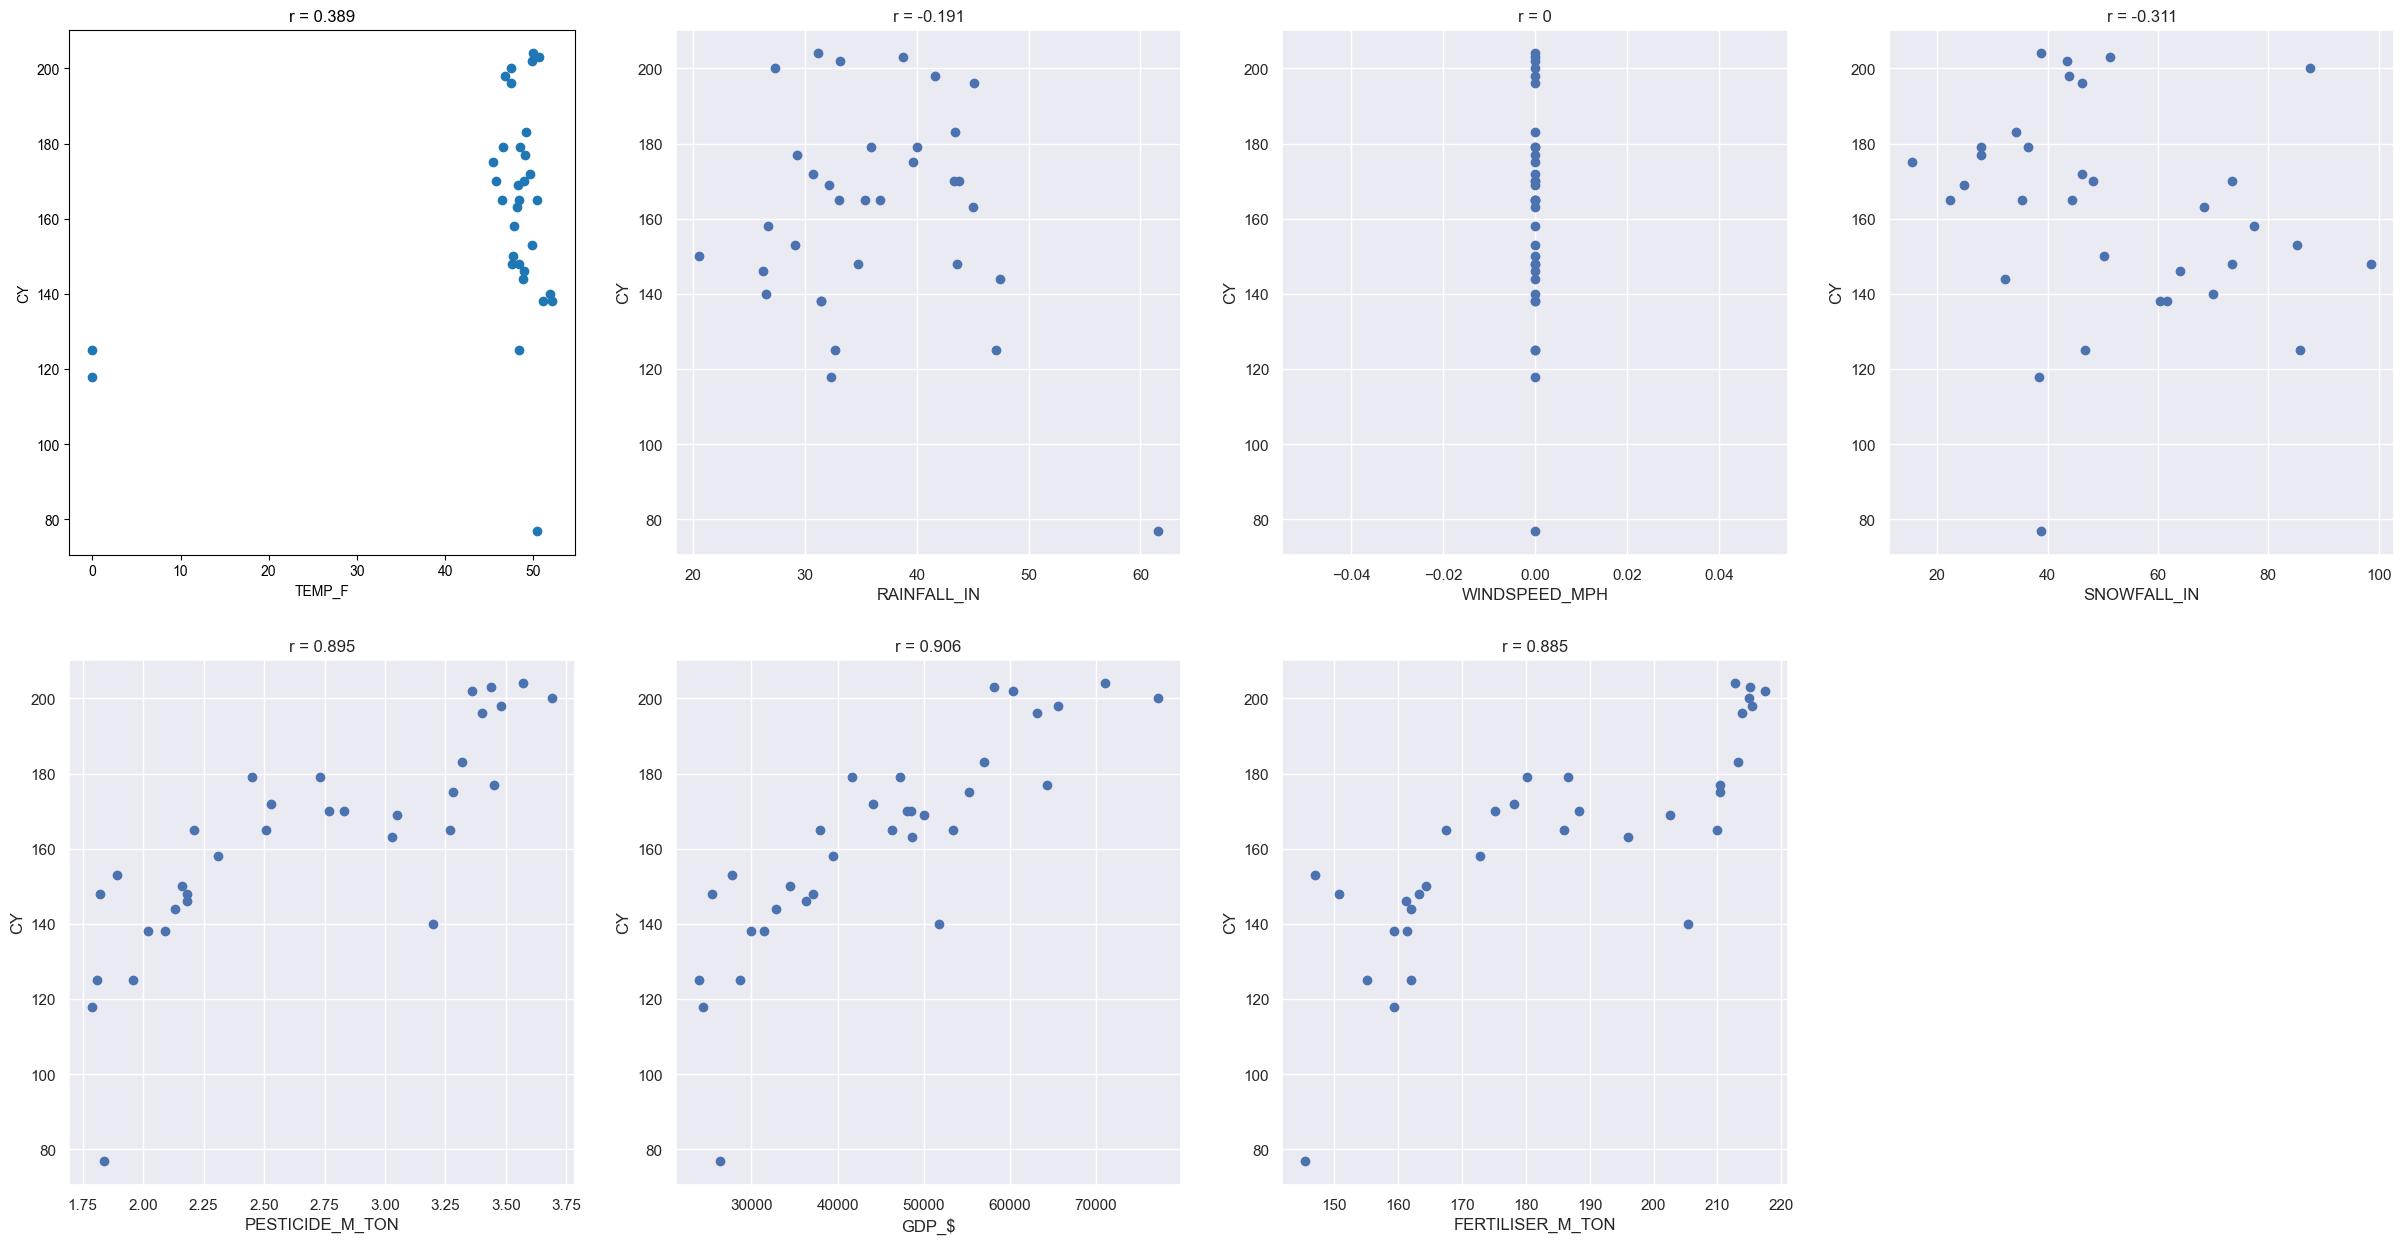

In [5]:
"""
Relationship between each dependant and independant variable

"""
plt.figure(figsize=(30, 15))

i = 1
for var in vars:
    plt.subplot(2, 4, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/correlation.png")
# plot_data(df, dep[VAR_PEST], VAR_C)

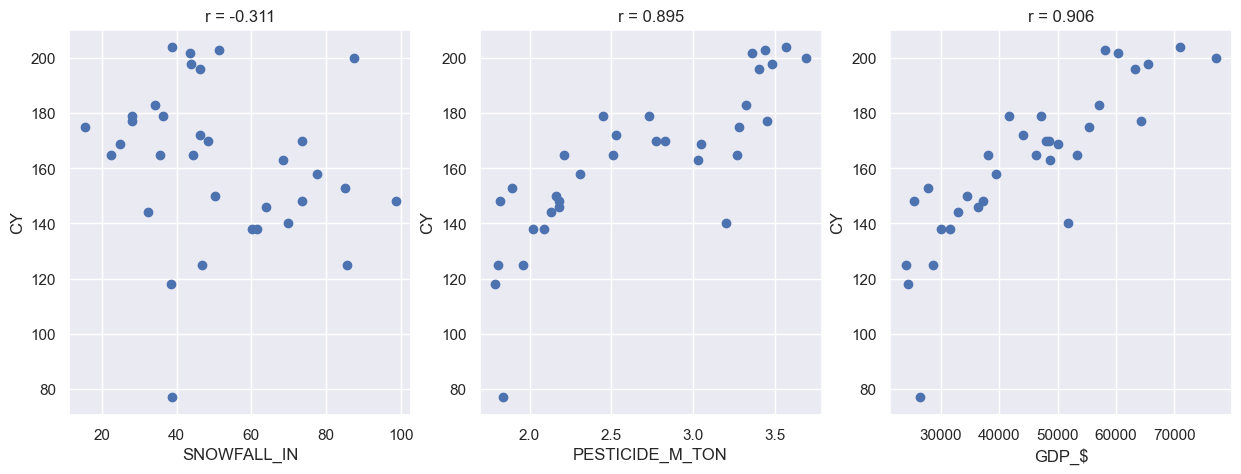

In [6]:

VAR_SNOW: 'SNOWFALL_IN'
VAR_PEST: 'PESTICIDE_M_TON'
VAR_GDP: 'GDP_$'

chosen_dep = [VAR_SNOW, VAR_PEST, VAR_GDP]

plt.figure(figsize=(15, 5))

i = 1
for var in chosen_dep:
    plt.subplot(1, 3, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/chosendep.png")

In [29]:

# Data transformation
from regression_functions import MVF
f, t = get_numpy_features(df, ['SNOWFALL_IN', 'PESTICIDE_M_TON', 'GDP_$'], [VAR_CU])
model = MVF(f, t)
model.normalize_data()
model.gradient_descent()
print(model.weights)
# print(model.costs)
print(model.predictions)

[[-0.08994607]
 [ 0.37866315]
 [ 0.51020136]]
[[123.64554395]
 [124.48747547]
 [120.18823197]
 [126.6484965 ]
 [124.04225483]
 [125.65150506]
 [129.70965096]
 [131.61935918]
 [135.87384635]
 [135.86101993]
 [136.23728629]
 [135.97619989]
 [141.69230924]
 [139.06629304]
 [147.09033775]
 [148.260627  ]
 [149.81127156]
 [151.82734319]
 [155.29597396]
 [154.05494343]
 [156.10194502]
 [161.41056313]
 [160.52292984]
 [165.80474392]
 [169.1899819 ]
 [169.28972035]
 [170.15687727]
 [171.44216649]
 [173.87512422]
 [176.89781656]
 [177.04329936]
 [182.68153977]
 [184.45332263]]


In [ ]:
from matplotlib import pyplot as plt

def plot_with_constant_variable(model, constant_feature_index, constant_value=None):
        """
        Parameters:
        X (numpy.ndarray): Feature matrix including the bias term.
        y (numpy.ndarray): Target variable.
        weights (numpy.ndarray): Regression weights.
        constant_feature_index (int): Index of the feature to keep constant (1-based index excluding bias).
        constant_value (float): Value to fix for the constant feature. If None, its mean is used.
        """

        y_mean, y_std = model.get_dep_mean_std
        x_mean, x_std = model.get_ind_mean_std

        x_with_bias = model.get_biased_ind

        x1_varied = np.linspace(X[:, feature1].min(), X[:, feature1].max(), 50)
        x2_varied = np.linspace(X[:, feature2].min(), X[:, feature2].max(), 50)
        X1, X2 = np.meshgrid(x1_varied, x2_varied)

        X_copy = np.zeros((len(x_varied), x_with_bias.shape[1]))
        X_copy[:, 0] = 1  # Bias term
        X_copy[:, feature_to_vary] = x_varied
        X_copy[:, constant_feature_index] = constant_value

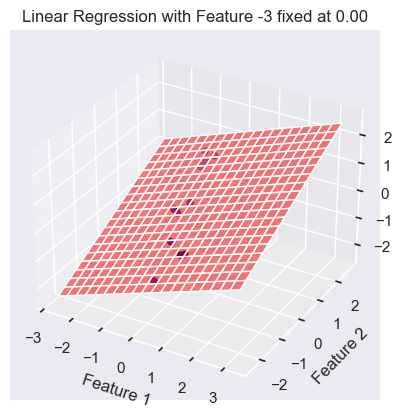

In [28]:
plot_with_constant_variable(model, -3)

In [40]:
%load_ext autoreload
%autoreload 2